<a href="https://colab.research.google.com/github/StinaFia/cv/blob/main/loan_approval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Loan Approval Dataset</h1>

Kokoelma taloudellisia tietoja joita voidaan käyttää määrittämään yksilön tai organisaation lainakelpoisuus Intiassa.

<b>Datan lähde:</b>

https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset?select=loan_approval_dataset.csv

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
# Yhdistetään Driveen.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Haetaan data df muuttujaan.
df = pd.read_csv('/content/drive/My Drive/AI2024/loan_approval_dataset.csv')
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


Tarkistetaan datasetti NaN arvojen varalta

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


Datan siivous

In [ ]:
# Poistetaan turhat sarakkeet.
df.drop(columns=['loan_id'], inplace=True)

In [ ]:
print(df.columns)

Index([' no_of_dependents', ' education', ' self_employed', ' income_annum',
       ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')


In [ ]:
# Poistetaan välit sarakkeiden nimien edestä https://www.w3schools.com/python/ref_string_strip.asp.
df.columns = df.columns.str.strip()
print(df.columns)

Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'loan_status'],
      dtype='object')


In [ ]:
# LabelEncoderia muuttamaan string arvot numeerisiksi.
le = LabelEncoder()

df['education'] = le.fit_transform(df['education'])
df['self_employed'] = le.fit_transform(df['self_employed'])
df['loan_status'] = le.fit_transform(df['loan_status'])
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,0,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,0
1,0,1,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,1
2,3,0,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,1
3,3,0,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,1
4,5,1,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,1


<h2>Määritellään koulutuksessa käytettävät sarakkeet ja kohdeluokka skaalatulla datalla</h2>

https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html

In [ ]:
scaler = StandardScaler()

# Poistetaan 'loan_status' jotta saadaan feature sarakkeet
# Määritellään kohdemuuttuja
X = df.drop(columns=['loan_status'])
y = df['loan_status']

numerical_data = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
                  'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']

# Skaalataan numeeriset arvot
X[numerical_data] = scaler.fit_transform(X[numerical_data])

In [ ]:
X.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
0,-0.294102,0,0,1.617979,1.633052,0.192617,1.032792,-0.780058,2.877289,0.832028,0.930304
1,-1.473548,1,1,-0.341750,-0.324414,-0.508091,-1.061051,-0.733924,-0.631921,-0.694993,-0.515936
2,0.295621,0,0,1.439822,1.610933,1.594031,-0.544840,-0.057300,-0.107818,1.996520,2.407316
3,0.295621,0,0,1.119139,1.721525,-0.508091,-0.771045,1.649637,-0.381263,0.897943,0.899533
4,1.475067,1,1,1.689242,1.002681,1.594031,-1.264055,0.757724,0.735304,1.568075,0.007172


In [ ]:
y.head()

,loan_status
0,0
1,1
2,1
3,1
4,1


In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3415, 11), (854, 11), (3415,), (854,))

<h2>Decision Tree</h2>

https://scikit-learn.org/1.5/modules/generated/sklearn.tree.DecisionTreeClassifier.html

DecisionTreeClassifier mallin koulutus

In [ ]:
# max_depth=2 -> acc 96%
# max_depth=3 -> acc 96%
# max_depth=5 -> acc 97%
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

Ennustetaan testidatalla ja lasketaan ennusteen ja oikean tuloksen avulla  tarkkuus.

In [ ]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Tarkkuus: {acc}")

Tarkkuus: 0.9637002341920374


Visualisoidaan puu

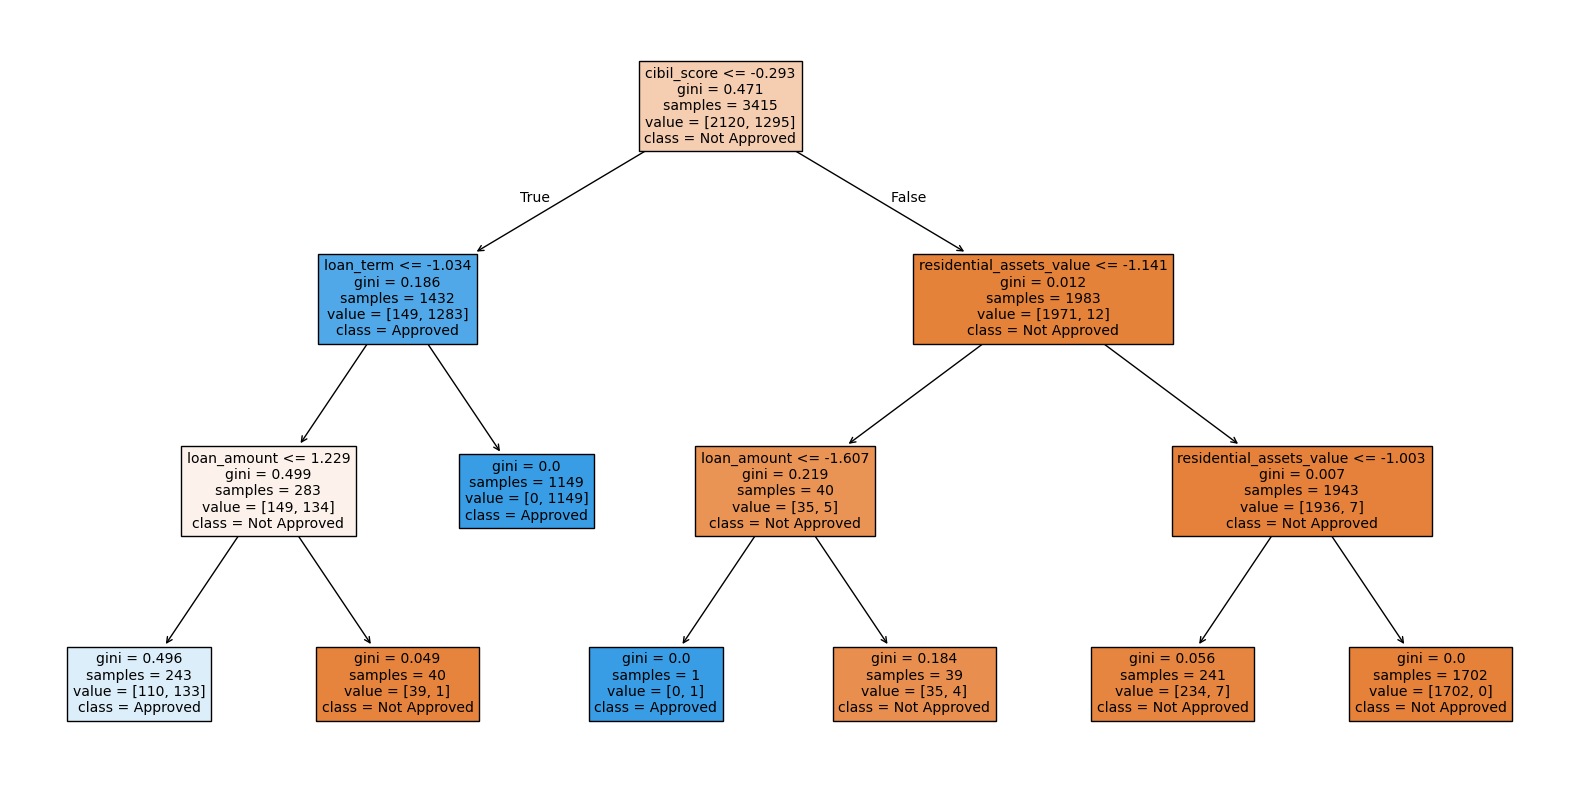

In [ ]:
# plot_tree funktio
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Not Approved', 'Approved'])
plt.show()

Confusion matrix

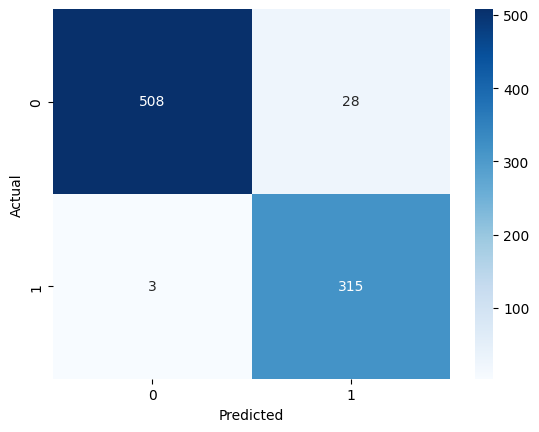

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<h2>Random Forest</h2>

https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html

RandomForestClassifier mallin koulutus

In [ ]:
rf_clf = RandomForestClassifier(max_depth=20, n_estimators=200)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200)

Ennustetaan testidatalla ja lasketaan ennusteen ja oikean tuloksen avulla  tarkkuus.

In [ ]:
# accuracy_score = 98%
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Tarkkuus: {acc}")

Tarkkuus: 0.977751756440281


Valitaan yksi päätöspuu satunnaismetsästä visualisointia varten

<function matplotlib.pyplot.show(close=None, block=None)>

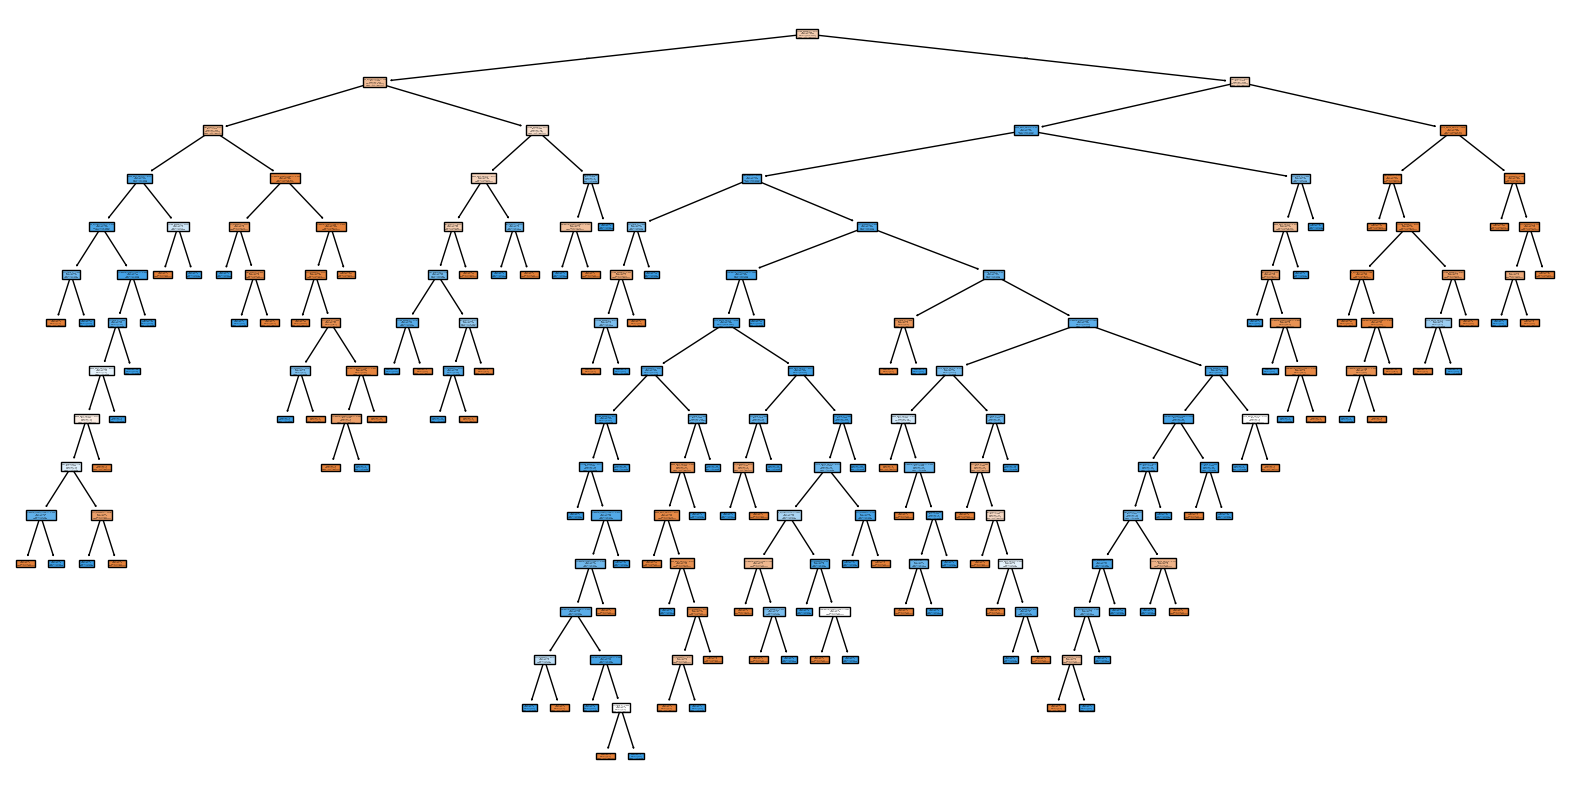

In [ ]:
# Valitaan ensimmäinen puu
estimator = rf_clf.estimators_[0]
# -> plot_tree
plt.figure(figsize=(20,10))
plot_tree(estimator, filled=True, feature_names=X.columns, class_names=['Not Approved', 'Approved'])
plt.show

Visualisoidaan ominaisuuksien tärkeydet ennusteen kannalta:
https://pandas.pydata.org/docs/reference/api/pandas.Series.plot.bar.html

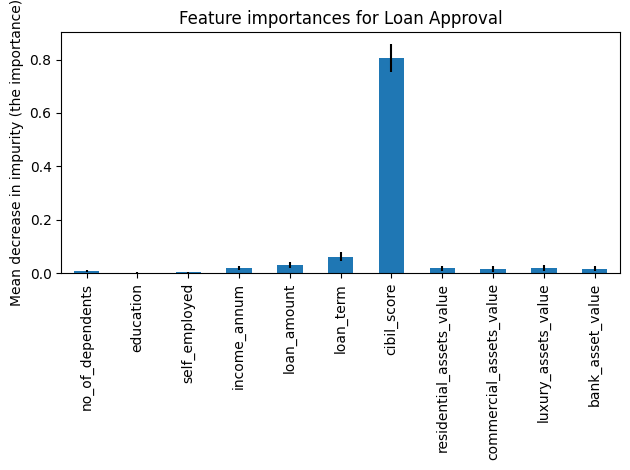

In [ ]:
# Tallennetaan muuttujaan koulutetun mallin feature_importances_
importances = rf_clf.feature_importances_

# Luodaan pandas series datan visualisointia varten
forest_importances = pd.Series(importances, index=X.columns)

# Määritellään standard deviation
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)

# plot.bar
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances for Loan Approval")
ax.set_ylabel("Mean decrease in impurity (the importance)")
fig.tight_layout()

Confusion matrix

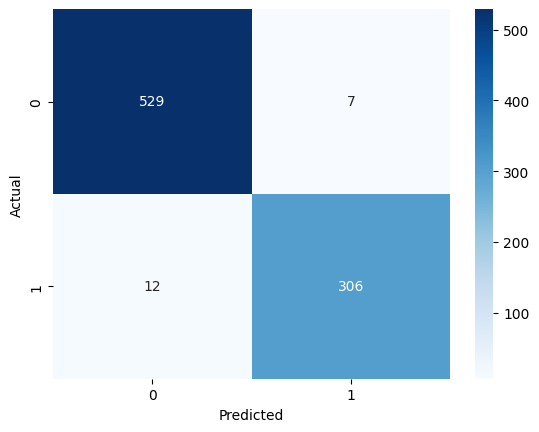

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<h2>Logistic Regression</h2>

https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html

Logistic Regression mallin koulutus

In [ ]:
logistic_reg = LogisticRegression(random_state=42)
logistic_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

Ennustetaan testidatalla ja lasketaan ennusteen ja oikean tuloksen avulla  tarkkuus.

In [ ]:
# accuracy_score = 91%
y_pred = logistic_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Tarkkuus: {acc}")

Tarkkuus: 0.905152224824356


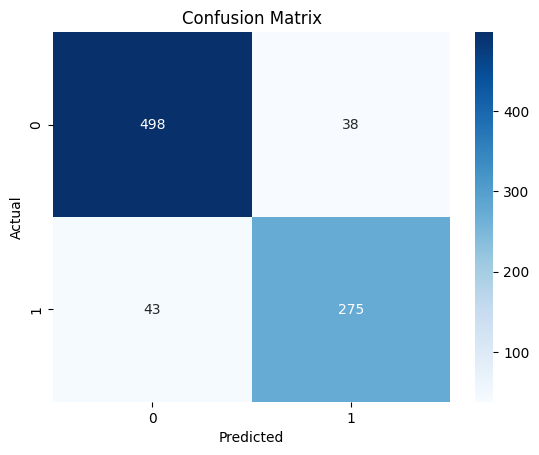

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<h2>Voting Classifier</h2>

Tallennetaan jokainen malli omaan muuttujaan

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
logistic_reg = LogisticRegression(random_state=42)

Luodaan yksittäisistä malleista yhteinen ryhmä VotingClassifierin avulla: https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.VotingClassifier.html

In [ ]:
# Luotu Geminillä
ensemble_classifier = VotingClassifier(estimators=[
    ('decision_tree', decision_tree),
    ('random_forest', random_forest),
    ('logistic_reg', logistic_reg)
], voting='soft')

Mallin koulutus

In [ ]:
ensemble_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('decision_tree',
                              DecisionTreeClassifier(random_state=42)),
                             ('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('logistic_reg',
                              LogisticRegression(random_state=42))],
                 voting='soft')

Tarkkuus

In [ ]:
# Tarkkuus = 98%
y_pred = ensemble_classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Tarkkuus: {acc}")

Tarkkuus: 0.9789227166276346


Confusion matrix

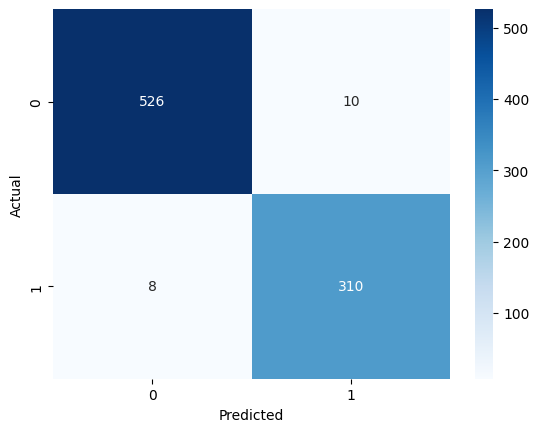

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()